In [22]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import csv
import random
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#check if guess
def is_guess(model, line):
    if not model.has_index_for(line['question']):
        return True
    for i in range(4):
        if model.has_index_for(line[str(i)]):
            return False
    return True

In [3]:
#find the closest synonym to the question-word. Use the similarity method from Gensim.
def guess_synonym(model):
    with open('synonyms.csv', 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        output_data = []
        most_similar = 0
        guess_word = ""
        label = ""
        for line in csv_reader:
            for i in range(4):
                if (is_guess(model, line)):
                    random_word_key = random.randint(0,3)
                    guess_word = line[str(random_word_key)]
                    label = "guess"
                    break
                if not model.has_index_for(line[str(i)]):
                    continue
                else:
                    model_similarity = model.similarity(line['question'], line[str(i)])
                if (model_similarity > most_similar):
                    most_similar = model_similarity
                    guess_word = line[str(i)]
            if (label != "guess"):
                label = "correct" if (guess_word == line['answer']) else "wrong"

            output_data.append({"question": line['question'], "answer": line['answer'], "guess": guess_word, "label": label})
            most_similar = 0
            guess_word = ""
            label = ""
        return output_data

In [4]:
#write results to csv file
def write_results(model_name, data):
    with open(f'{model_name}-details.csv', 'w') as new_file:
        fieldnames = data[0].keys()
        csv_writer = csv.DictWriter(new_file, fieldnames, lineterminator = '\n')
        csv_writer.writeheader()
        csv_writer.writerows(data)

In [5]:
#write analysis file
def write_analysis(model_name, model, results):
    vocab_size = len(model)
    results_per_label = Counter(element['label'] for element in results)
    c = results_per_label['correct']
    v = 80-results_per_label['guess']
    model_accuracy = c/v
    with open('analysis.csv', 'a') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow([model_name, vocab_size, c, v, model_accuracy])

In [6]:
#load the pretrained embedding models, store the results, perform the analysis
model_names = ["glove-twitter-50", "glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200"]
for model_name in model_names:
    model = api.load(model_name)
    output_data = guess_synonym(model)
    write_results(model_name, output_data)
    write_analysis(model_name, model, output_data)

[==================================================] 100.0% 199.5/199.5MB downloaded
[==================================================] 100.0% 66.0/66.0MB downloaded
[==================================================] 100.0% 128.1/128.1MB downloaded
[==================================================] 100.0% 252.1/252.1MB downloaded


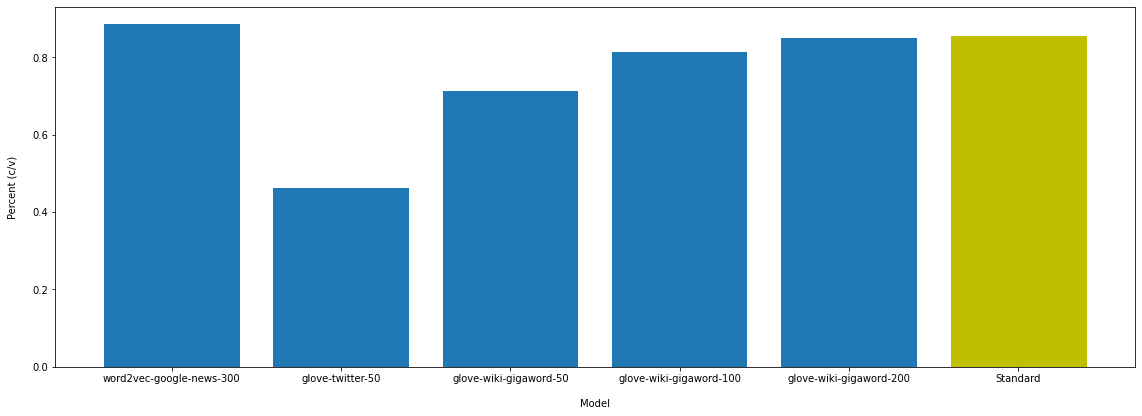

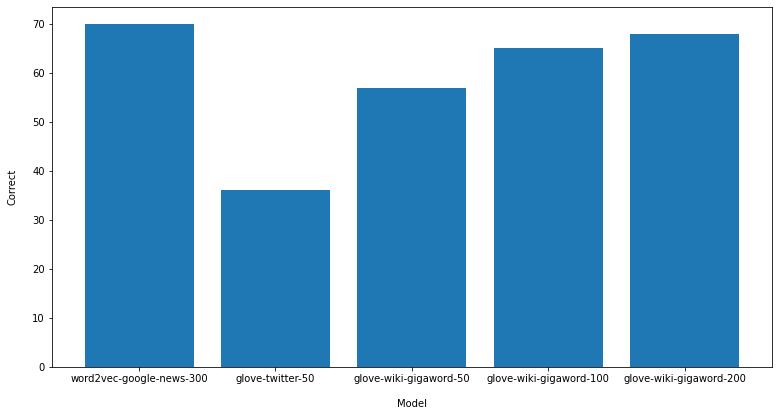

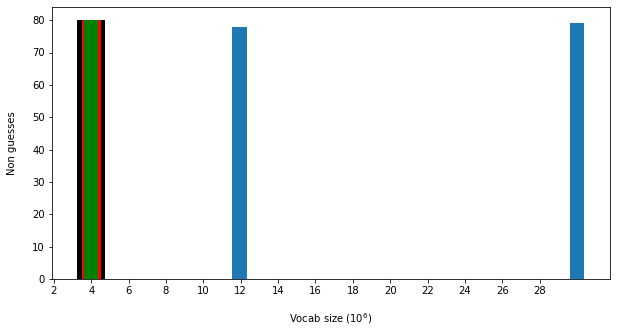

In [55]:
headers = ['model', 'vocab', 'c', 'v', 'percent']
df = pd.read_csv('analysis.csv', names=headers)

#Pecent vs model bar chart
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
x_axis = df['model'].tolist()
y_axis = df['percent'].tolist()
x_axis.append("Standard")
y_axis.append(0.8557)
bars = ax.bar(x_axis,y_axis)
bars[-1].set_color('y')
plt.xlabel("Model", labelpad=15)
plt.ylabel("Percent (c/v)", labelpad=15)
plt.show()

#Correct vs Model bar chart
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
x_axis = df['model'].tolist()
y_axis = df['c'].tolist()
ax.bar(x_axis,y_axis)
plt.xlabel("Model", labelpad=15)
plt.ylabel("Correct", labelpad=15)
plt.show()

#Correct vs Model bar chart
fig = plt.figure(figsize=(10, 5))
y_axis = df['v'].tolist()
x_axis = (df['vocab']/(10**5)).tolist()

dups_x = np.array([],dtype=np.float64)
dups_y = np.array([],dtype=np.float64)

for i in range(len(x_axis)):
    if x_axis.count(x_axis[i]) > 1:
        dups_x = np.append(dups_x,x_axis[i])
        dups_y = np.append(dups_y,y_axis[i])
for i in range(len(dups_x)):
    x_axis.remove(dups_x[i])
    y_axis.remove(dups_y[i])
color=['black', 'red', 'green', 'blue', 'cyan']
plt.xticks(np.arange(0,max(x_axis), len(x_axis)))
plt.bar(x_axis,y_axis)
for i in range(len(dups_x)):
    plt.bar(dups_x[i],dups_y[i], color=color[i], width=len(dups_x)/(i+2))
plt.ylabel("Non guesses", labelpad=15)
plt.xlabel("Vocab size $(10^6)$", labelpad=15)
plt.show()

In [8]:
#Table of most successful answers of standard compared to result of models
gold_standard_df = pd.read_csv("Crowdsourced Gold-Standard for MP3.csv")
gold_standard_df['Sucess Rate'] = gold_standard_df['Sucess Rate'].str.replace('%', '').astype(float)
top10_sucess = gold_standard_df.nlargest(10, 'Sucess Rate')

model_names = ["word2vec-google-news-300", "glove-twitter-50", "glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200"]
for model_name in model_names:
    model_header = ['question', 'answer', 'guess', model_name]
    df_model = pd.read_csv(f'{model_name}-details.csv', names=model_header)
    df_model = df_model.loc[df_model['question'].isin(top10_sucess['Question name'].tolist())]
    df_model = df_model.drop(columns=['guess'])
    if (model_name == model_names[0]):
        df_compiled = df_model;
    else:
        df_compiled[model_name] = df_model[model_name].tolist();

df_compiled

,question,answer,word2vec-google-news-300,glove-twitter-50,glove-wiki-gigaword-50,glove-wiki-gigaword-100,glove-wiki-gigaword-200
1,enormously,tremendously,correct,correct,correct,correct,correct
12,solitary,alone,wrong,wrong,wrong,wrong,correct
20,costly,expensive,correct,correct,correct,correct,correct
24,often,frequently,correct,wrong,correct,correct,correct
27,narrow,thin,correct,wrong,wrong,correct,correct
28,arranged,planned,correct,correct,correct,correct,correct
29,infinite,limitless,correct,wrong,correct,correct,correct
51,built,constructed,correct,wrong,correct,correct,correct
52,tasks,jobs,correct,wrong,correct,correct,correct
78,bigger,larger,correct,wrong,wrong,correct,correct


In [9]:
#Table of least successful answers of standard compared to result of model
top10_wrong = gold_standard_df.nsmallest(10, 'Sucess Rate')
for model_name in model_names:
    model_header = ['question', 'answer', 'guess', model_name]
    df_model = pd.read_csv(f'{model_name}-details.csv', names=model_header)
    df_model = df_model.loc[df_model['question'].isin(top10_wrong['Question name'].tolist())]
    df_model = df_model.drop(columns=['guess'])
    if (model_name == model_names[0]):
        df_compiled = df_model;
    else:
        df_compiled[model_name] = df_model[model_name].tolist();

df_compiled

,question,answer,word2vec-google-news-300,glove-twitter-50,glove-wiki-gigaword-50,glove-wiki-gigaword-100,glove-wiki-gigaword-200
2,provisions,stipulations,correct,wrong,correct,correct,correct
3,haphazardly,randomly,correct,wrong,correct,correct,wrong
23,make,earn,correct,wrong,correct,correct,correct
30,showy,striking,wrong,wrong,wrong,wrong,wrong
35,prolific,productive,correct,wrong,wrong,correct,correct
37,peculiarly,uniquely,correct,guess,correct,correct,correct
56,wildly,furiously,correct,correct,correct,correct,correct
57,hailed,acclaimed,wrong,wrong,wrong,wrong,wrong
74,figure,solve,correct,wrong,wrong,wrong,wrong
76,fashion,manner,correct,wrong,correct,correct,correct
